In [1]:
import numpy                as np
import matplotlib.pyplot    as plt
from astropy import units   as units
import datetime as dt
import sys
from pathlib            import Path
from matplotlib         import rcParams, rc
from scipy.interpolate  import interp1d
import types
# Change the matplotlib default parameters
rcParams.update({'font.size':   8})
rcParams.update({'figure.dpi': 120})

sys.path.append('/lhome/silkem/ChemTorch/ChemTorch/')
from src.read               import read_data_chemtorch
# from src.rates          import *
from src.solve_n_save       import solve_dg
from src.input              import density

rate = 16

outloc = '/lhome/silkem/ChemTorch/ChemTorch/out/'
samploc = '/lhome/silkem/ChemTorch/ChemTorch/sampling/'
dataloc = '/lhome/silkem/ChemTorch/PhantomSampling/'

## Getting sampling functions from Phantom distributions

In [23]:
def get_dist(nbins,file):
    data = np.loadtxt(dataloc+file+'.txt')
    out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)
    plt.title(file)
    plt.plot(out[1][:-1],out[0])
    # plt.xlim(-0.002, 0.0005)
    plt.show()
    return out


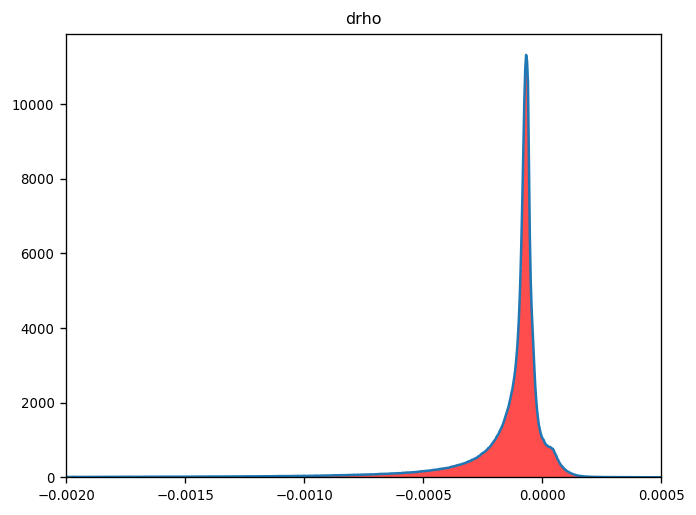

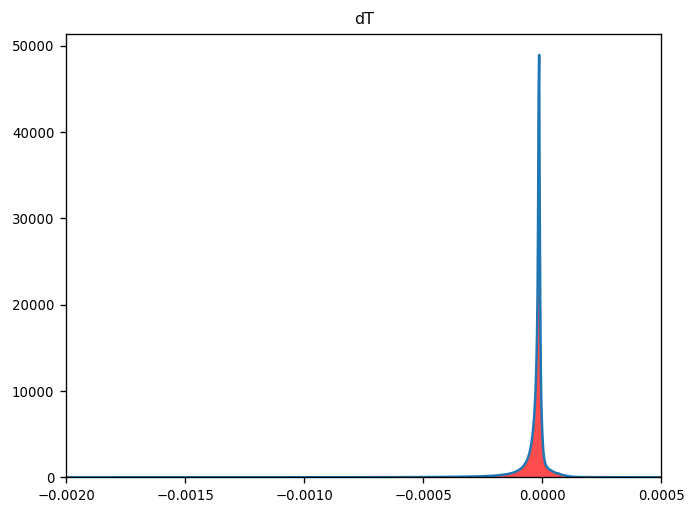

In [7]:
## diif density & temperature distributions

nbins = 100000
file = 'drho'
out_rho = get_dist(nbins, file)
file = 'dT'
out_temp = get_dist(nbins, file)


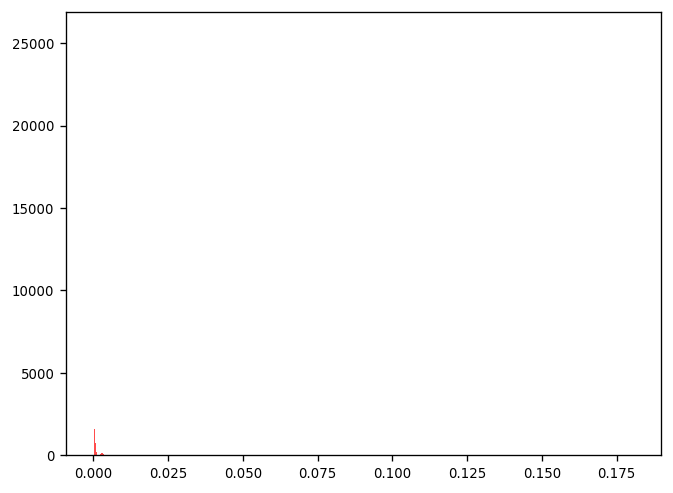

In [24]:
## dt distributions

nbins = 100000
dt1 = np.loadtxt(dataloc+'dtime1'+'.txt')
dt2 = np.loadtxt(dataloc+'dtime2'+'.txt')
dt3 = np.loadtxt(dataloc+'dtime3'+'.txt')
data = np.concatenate((dt1,dt2,dt3), axis = 0)  

# print(data.shape)

out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)


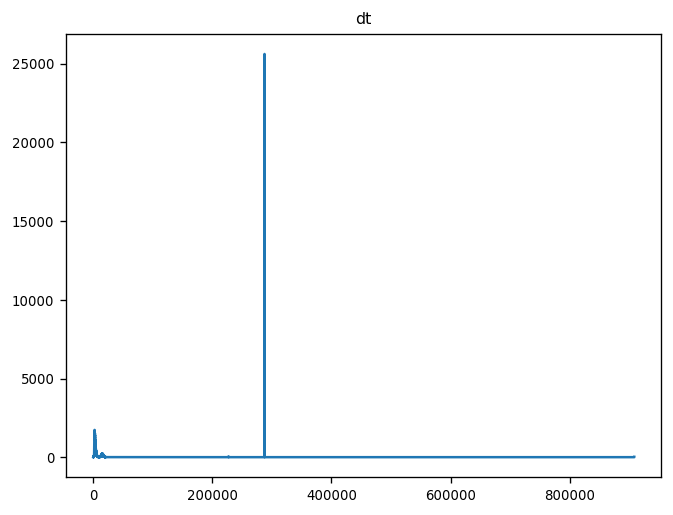

In [26]:
plt.title('dt')
plt.plot((out[1][:-1]*5022728.790082334),out[0])  ## because in PHANTOM code units ---> [sec]
# plt.xlim(-0.002, 0.075)
# plt.xscale('log')
plt.show()

In [27]:
np.save(samploc+'dtime', out[0])
np.save(samploc+'dtime_range', (out[1][:-1]*5022728.790082334)) 

In [11]:
np.save(samploc+'drho', out_rho[0]) 
np.save(samploc+'dT', out_temp[0]) 

In [16]:
np.save(samploc+'drho_range', out_rho[1][:-1]) 
np.save(samploc+'dT_range', out_temp[1][:-1]) 

## Data generation


In [7]:
## Ranges from PHANTOM models
ρ_min = min(np.load(samploc+'drho_range.npy'))
ρ_max = max(np.load(samploc+'drho_range.npy'))
T_min = min(np.load(samploc+'dT_range.npy'))
T_max = max(np.load(samploc+'dT_range.npy'))
δ_min = 1.e-6
δ_max = 1
Av_min = -1
Av_max = -np.log(δ_max)
dt_min = min(np.load(samploc+'dtime_range.npy'))
dt_max = max(np.load(samploc+'dtime_range.npy'))

nstep = 512

In [6]:
print((dt_min) /units.year.to('s')   , (dt_max) /units.year.to('s')    )
print(np.median(np.load(samploc+'dtime_range.npy'))/units.year.to('s') )

7.084241464704688e-08 0.028791877456836677
0.014395974149625661


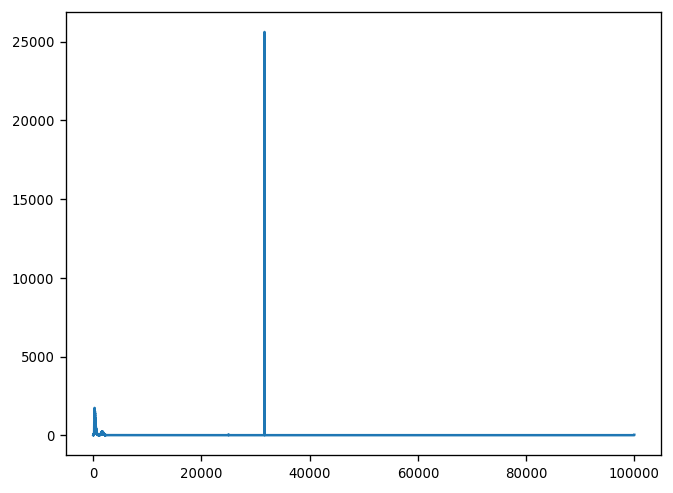

In [31]:
time_func = np.load(samploc+'dtime.npy') 
rho_func = np.load(samploc+'drho.npy') 
plt.plot(time_func)
# plt.plot(rho_func)
# plt.xscale('log')

In [8]:
### !!! HIER VERONDERSTELLEN WE ONGECORRELEERDE PARAMETERS


def fdens(x):
	rho_func = np.load(samploc+'drho.npy') 
	return rho_func

def ftemp(x):
	T_func = np.load(samploc+'dT.npy') 
	return T_func

def fdelta(x):
	return np.ones_like(x)

def fAv(x):
	return np.ones_like(x)

# def fdt(x):
# 	return x**3./(-1.+np.exp(-x+3.8001))

def fdt(x):
	time_func = np.load(samploc+'dtime.npy') 
	return time_func

## cummulative sum 
## generate random numbers between [0,1)
## Define a function to return N samples
def genSamples(xmin, xmax, nstep, N, f):
	xbin = np.linspace(xmin, xmax, nstep)
	# print(xmin,xmax)
	ycum = np.cumsum(f(xbin))
	# plt.plot(ycum)
	xbin = np.linspace(xmin, xmax, len(ycum))
	u = np.random.uniform(ycum.min(), ycum.max(), int(N))
	## take the inverse of cumm. function
	func_interp = interp1d(ycum, xbin)
	samples = func_interp(u)
	return samples
	

def calc_next(f, param_i, min, max, nstep):
	N = 1
	ε = genSamples(min, max, nstep, N, f)
	# print(ε)
	param_next = (ε + 1)*param_i
	return param_next[0]

def next_input_idv(ρ, T, δ, Av):
	ρ_next  = calc_next(fdens , ρ , ρ_min , ρ_max , nstep)
	T_next  = calc_next(ftemp , T , T_min , T_max , nstep)
	δ_next  = calc_next(fdelta, δ , δ_min , δ_max , nstep)
	Av_next = calc_next(fAv   , Av, Av_min, Av_max, nstep)
	return ρ_next, T_next, δ_next, Av_next

def next_input(input):
	ρ = input[0]
	T = input[1]
	δ = input[2]
	Av= input[3]
	ρ_next  = calc_next(fdens , ρ , ρ_min , ρ_max , nstep)
	T_next  = calc_next(ftemp , T , T_min , T_max , nstep)
	δ_next  = calc_next(fdelta, δ , δ_min , δ_max , nstep)
	Av_next = calc_next(fAv   , Av, Av_min, Av_max, nstep)
	# print(ρ_next.type)
	return [ρ_next, T_next, δ_next, Av_next]

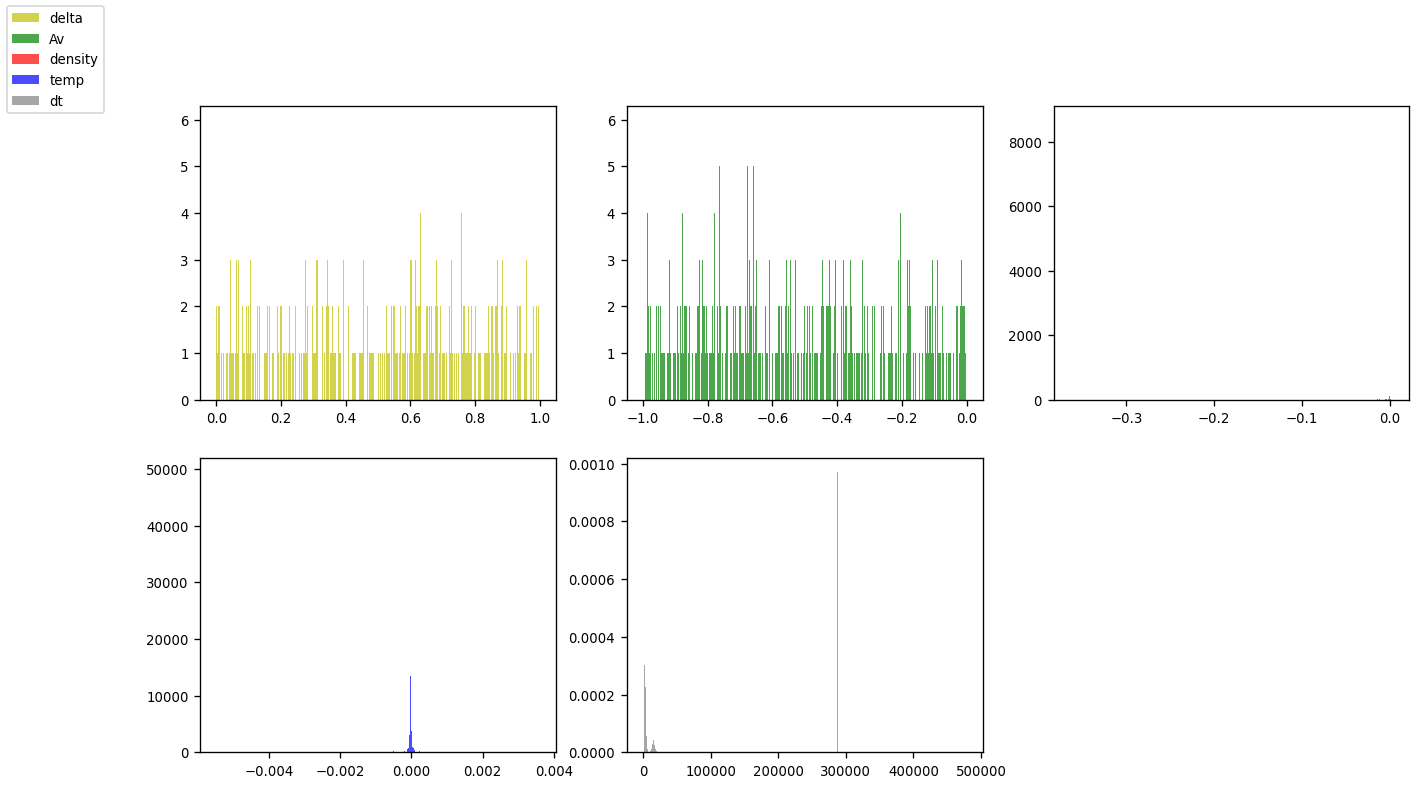

In [33]:
nsamples = 1.e4
nbins = 10000

dens_samples = genSamples(ρ_min, ρ_max, nstep, nsamples, fdens)
temp_samples = genSamples(T_min, T_max, nstep, nsamples, ftemp)
delt_samples = genSamples(δ_min, δ_max, nstep, nsamples, fdelta)
Av_samples = genSamples(Av_min, Av_max, nstep, nsamples, fAv)
dt_samples = genSamples(dt_min, dt_max, nstep, nsamples, fdt)

fig = plt.figure(figsize=(13,7))

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(234)
ax5 = plt.subplot(235)

ax1.hist(delt_samples,bins=nbins, density=True, color='y', alpha=0.7, label = 'delta')
ax2.hist(Av_samples  ,bins=nbins, density=True, color='g', alpha=0.7, label = 'Av')
ax3.hist(dens_samples,bins=nbins, density=True, color='r', alpha=0.7, label = 'density')
ax4.hist(temp_samples,bins=nbins, density=True, color='b', alpha=0.7, label = 'temp')
ax5.hist(dt_samples  ,bins=nbins, density=True, color='grey', alpha=0.7, label = 'dt')

fig.legend(loc = 'upper left')
plt.show()

In [19]:
ρ_i  = 1.13E+05
T_i  = 2500
δ_i  = 1.e-1
Av_i = -np.log(1.e-3)

ρ, T, δ, Av = next_input_idv(ρ_i, T_i, δ_i, Av_i)
# print('')
ρ2, T2, δ2, Av2 = next_input_idv(ρ, T, δ, Av)
# print('')
ρ3, T3, δ3, Av3 = next_input_idv(ρ2, T2, δ2, Av2)
# print('')
ρ4, T4, δ4, Av4 = next_input_idv(ρ3, T3, δ3, Av3)

print('')
print('density',ρ_i, ρ, ρ2, ρ3, ρ4)
print('temp   ',T_i, T, T2, T3, T4)
print('delta  ',δ_i, δ, δ2, δ3, δ4)
print('Av     ',Av_i, Av, Av2, Av3, Av4)



density 113000.0 112990.68112041305 112982.79921169461 112978.88655530919 112971.90958628838
temp    2500 2499.7815255486835 2499.746658648574 2499.693655626021 2499.650152648665
delta   0.1 0.11307688656149686 0.19531898676809933 0.3724465249283429 0.6058404542645064
Av      6.907755278982137 0.03639136069367637 0.0013674247351839113 0.0008846186428872267 0.0002486790264928117


IndexError: invalid index to scalar variable.

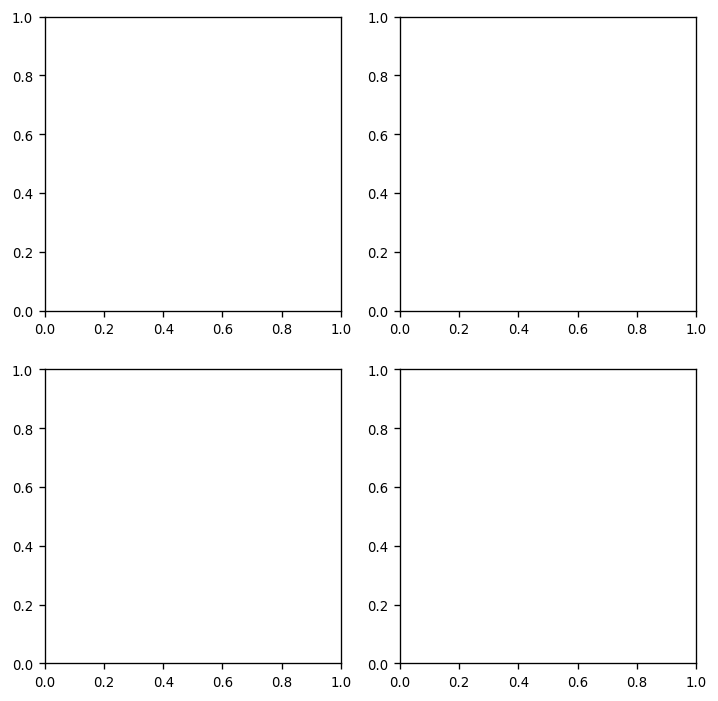

In [11]:
fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,1]},figsize=(7, 7))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]
x = [0,1,2,3,4]

ax1.plot(x,np.array([ρ_i, ρ[0], ρ2[0], ρ3[0], ρ4[0]]), 'x-',c='r')
ax2.plot(np.array([T_i, T[0], T2[0], T3[0], T4[0]]), 'x-', c='b')
ax3.plot(np.array([δ_i, δ[0], δ2[0], δ3[0], δ4[0]]), 'x-', c = 'y')
ax4.plot(np.array([Av_i, Av[0], Av2[0], Av3[0], Av4[0]]), 'x-', c= 'g')

ax1.set_title('density', color='r')
ax2.set_title('temperature', color='b')
ax3.set_title('delta', color = 'y')
ax4.set_title('Av', color = 'g')

ax1.set_yscale('log')
ax3.set_yscale('log')



In [8]:
# elke run eigen map, uniek, date ofzo
# checken op andere computer dat wanneer ge random seeds maakt, dat de random getallen effectief anders zijn
# nu enkel variaties van variabelen, begin met een gekozen input
# starten van de chemie waar ge mee eindigd --> paden in de fysiochemische ruimte
# eind abundantie terug meegeven, niet initialiseren

In [9]:
import src.rates        as rates

chemtype = 'C'

## set initial conditions
n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code

ρi  = 1.13E+05
Ti  = 2500
δi  = 1.e-1
Avi = -np.log(1.e-3)
input = [ρi,Ti,δi,Avi]

Δt =  genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec
# print(Δt)

nf = solve_dg(input, Δt, rate, n, nshield_i, nconsv_tot)
    

------------------------------------------------------------------------------
Name:
2023-08-07 02:06:29.447361

Input:
[density, temperature, delta, Av] dt:
[113000.0, 2500, 0.1, 6.907755278982137] 287649.27

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 0.0091 yr...
The solver successfully reached the end of the integration interval.
DONE! In 10.24 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-07 02:06:29.447361/
------------------------------------------------------------------------------


In [8]:
nf.shape

(466,)

In [15]:
input2 = next_input(input)
Δt =  genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec
nf2 = solve_dg(input2, Δt, rate, nf, nshield_i, nconsv_tot)

------------------------------------------------------------------------------
Name:
2023-08-07 02:13:11.924681

Input:
[density, temperature, delta, Av] dt:
[112991.24757624304, 2499.957578627558, 0.10777252200983381, 6.68996589523922] 3314.76

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 0.0001 yr...
The solver successfully reached the end of the integration interval.
DONE! In 4.52 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-07 02:13:11.924681/
------------------------------------------------------------------------------


[1.13000000e+05 2.50000000e+03 1.00000000e-01 6.90775528e+00
 2.87649267e+05]
[10.24108315  0.02668953]


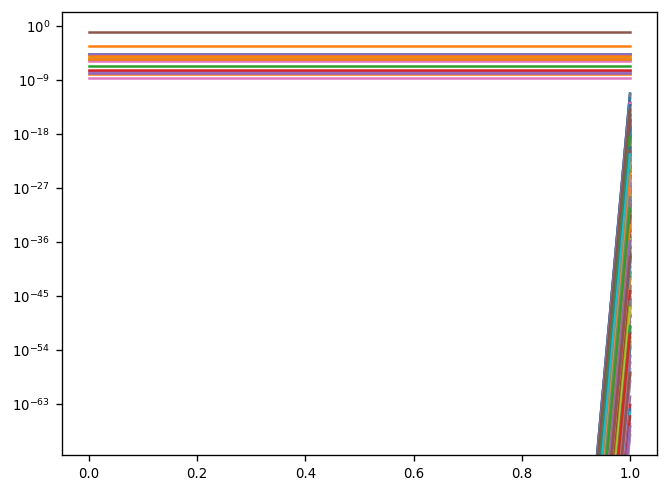

In [13]:

path = '/lhome/silkem/ChemTorch/ChemTorch/out/2023-08-07 02:06:29.447361/'

print(np.load(path+'input.npy'))
print(np.load(path+'tictoc.npy'))
# print(np.load(path+'abundances.npy'))
abs = np.load(path+'abundances.npy')

for i in range(abs.shape[0]):
    plt.plot(abs[i])

plt.yscale('log')

[1.12991248e+05 2.49995758e+03 1.07772522e-01 6.68996590e+00
 3.31475684e+03]
[4.52431154 0.03531456]
[[4.83069094e-12 4.90259564e-12]
 [4.15970822e-14 4.20753257e-14]
 [5.59389992e-16 5.65818910e-16]
 [5.04561226e-14 5.04574021e-14]
 [1.64643728e-12 1.66567989e-12]
 [8.50000000e-02 8.50000000e-02]
 [1.56834285e-13 1.58617418e-13]
 [7.43441725e-16 7.43444365e-16]
 [1.83428160e-28 1.89760425e-28]
 [1.52525380e-15 1.55896985e-15]
 [3.63082152e-12 3.67057563e-12]
 [4.93123647e-30 5.15259834e-30]
 [2.34396008e-17 2.39241222e-17]
 [6.82425441e-14 6.92245371e-14]
 [1.67254684e-17 1.70815848e-17]
 [6.30150069e-18 6.37807772e-18]
 [1.28165689e-13 1.31433247e-13]
 [7.48646171e-15 7.57282853e-15]
 [3.72538714e-15 3.86290406e-15]
 [1.34178352e-16 1.36565957e-16]
 [3.87065912e-18 3.91986869e-18]
 [1.61700586e-16 1.66907204e-16]
 [1.33046173e-19 1.34616654e-19]
 [1.38224160e-17 1.40524289e-17]
 [4.58990319e-18 4.64990627e-18]
 [2.19156061e-29 2.24133993e-29]
 [1.44663881e-16 1.46310737e-16]
 [3.037

(1e-15, 1.0)

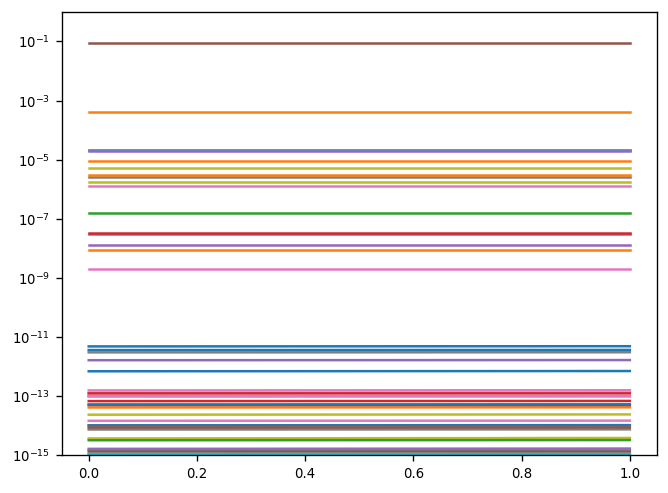

In [18]:

path = '/lhome/silkem/ChemTorch/ChemTorch/out/2023-08-07 02:13:11.924681/'

print(np.load(path+'input.npy'))
print(np.load(path+'tictoc.npy'))
print(np.load(path+'abundances.npy'))
abs = np.load(path+'abundances.npy')

for i in range(abs.shape[0]):
    plt.plot(abs[i])

plt.yscale('log')
plt.ylim([1e-15, 1e0])